In [12]:
import os
import cv2
import numpy as np
from PIL import Image
from pipeline import restore_head, restore_head_alpha_blend, restore_head_poisson_blend, restore_head_pyramid_blend

# Parameters
ALPHA = 0.75
PYRAMID_LEVEL = 4

# Folders
image_folder = "qualitative-analysis-images"
originals_folder = os.path.join(image_folder, "originals")
masks_folder = os.path.join(image_folder, "masks")
generated_folder = os.path.join("quantitative-analysis-images", "generated")

output_folder = "quantitative-analysis-images"
method_folders = {
    "mask_paste": os.path.join(output_folder, "mask_paste"),
    "alpha_blend": os.path.join(output_folder, "alpha_blend"),
    "poisson_blend": os.path.join(output_folder, "poisson_blend"),
    "pyramid_blend": os.path.join(output_folder, "pyramid_blend"),
}
for folder in method_folders.values():
    os.makedirs(folder, exist_ok=True)

# List all generated image files
gen_files = [f for f in os.listdir(generated_folder) if f.endswith('.jpg') or f.endswith('.png')]

for gen_file in gen_files:
    # Extract base ID (e.g., 00002_00) from filename
    base_id = gen_file.split('_')[0] + '_' + gen_file.split('_')[1]
    print(f"Processing {gen_file} (base id: {base_id})...")
    img_orig_path = os.path.join(originals_folder, f"{base_id}.jpg")
    if not os.path.exists(img_orig_path):
        img_orig_path = os.path.join(originals_folder, f"{base_id}.png")
    mask_path = os.path.join(masks_folder, f"{base_id}_head.png")
    gen_path = os.path.join(generated_folder, gen_file)

    if not (os.path.exists(img_orig_path) and os.path.exists(mask_path)):
        print(f"Missing original or mask for {base_id}, skipping.")
        continue

    img_gen = Image.open(gen_path).convert("RGB")
    img_orig = Image.open(img_orig_path).convert("RGB").resize(img_gen.size)
    head_mask = Image.open(mask_path).convert("L").resize(img_gen.size)

    # Apply restoration methods
    pasted = restore_head(img_orig.copy(), img_gen.copy(), head_mask)
    alpha_blended = restore_head_alpha_blend(img_orig.copy(), img_gen.copy(), head_mask, ALPHA)
    poisson_blended = restore_head_poisson_blend(img_orig.copy(), img_gen.copy(), head_mask)
    pyramid_blended = restore_head_pyramid_blend(img_orig.copy(), img_gen.copy(), head_mask, PYRAMID_LEVEL)

    # Save results using the full generated filename
    out_name = os.path.splitext(gen_file)[0] + ".png"
    pasted.save(os.path.join(method_folders["mask_paste"], out_name))
    alpha_blended.save(os.path.join(method_folders["alpha_blend"], out_name))
    poisson_blended.save(os.path.join(method_folders["poisson_blend"], out_name))
    pyramid_blended.save(os.path.join(method_folders["pyramid_blend"], out_name))


Processing 00002_00_Black_long-sleeve_top_with_black_formal_trousers._00.png (base id: 00002_00)...
Processing 00002_00_Gray_hoodie_with_baggy_jeans._02.png (base id: 00002_00)...
Processing 00002_00_Gray_hoodie_with_baggy_jeans._02.png (base id: 00002_00)...
Processing 00002_00_Knee-length_summer_dress_in_blue_with_small_pink_flowers._04.png (base id: 00002_00)...
Processing 00002_00_Knee-length_summer_dress_in_blue_with_small_pink_flowers._04.png (base id: 00002_00)...
Processing 00002_00_White_blouse_and_burgundy_midi_skirt._01.png (base id: 00002_00)...
Processing 00002_00_White_blouse_and_burgundy_midi_skirt._01.png (base id: 00002_00)...
Processing 00006_00_Black_long-sleeve_top_with_black_formal_trousers._03.png (base id: 00006_00)...
Processing 00006_00_Black_long-sleeve_top_with_black_formal_trousers._03.png (base id: 00006_00)...
Processing 00006_00_Knee-length_summer_dress_in_blue_with_small_pink_flowers._00.png (base id: 00006_00)...
Processing 00006_00_Knee-length_summer_d

gen_path: quantitative-analysis-images\mask_paste\00018_00_Black_long-sleeve_top_with_black_formal_trousers._00.png
orig_path: qualitative-analysis-images/originals\00018_00.png
mask_path: qualitative-analysis-images/masks\00018_00_head.png
Crop box: x=191, y=40, w=78, h=126


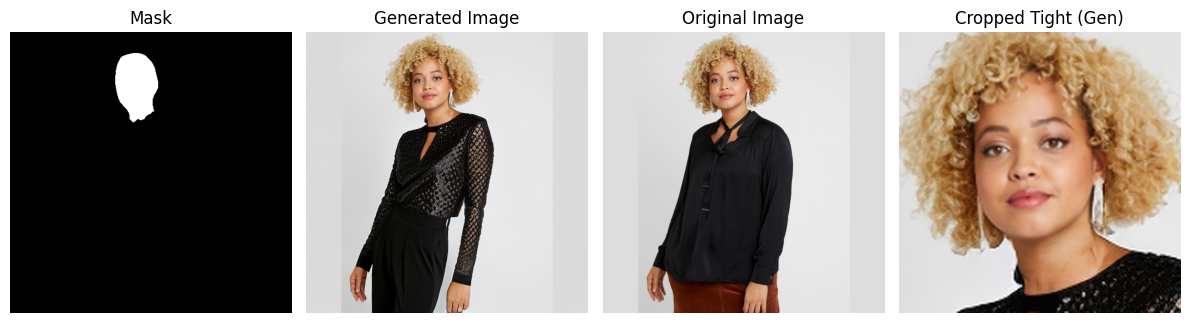

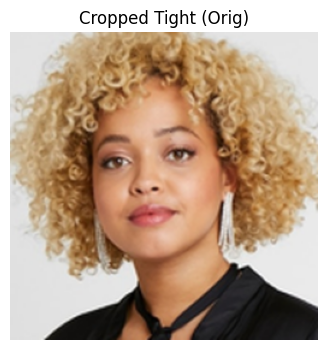

In [37]:
# --- Debug: Use imageid for orig and mask filenames ---
method = "mask_paste"  # Change to your method folder
orig_dir = "qualitative-analysis-images/originals"
gen_base_dir = "quantitative-analysis-images"
mask_dir = "qualitative-analysis-images/masks"
crop_size = 256

# Helper: crop a square region tightly around the head, with a small margin
# This will be more zoomed in on the head

def crop_tight_square_around_head(im, x, y, w, h, crop_size, margin_ratio=0.15):
    # Add a margin around the bounding box (e.g., 15% of max(w, h))
    margin = int(max(w, h) * margin_ratio)
    cx = x + w // 2
    cy = y + h // 2
    half_size = max(w, h) // 2 + margin
    left = max(cx - half_size, 0)
    top = max(cy - half_size, 0)
    right = min(cx + half_size, im.width)
    bottom = min(cy + half_size, im.height)
    crop = im.crop((left, top, right, bottom))
    # Resize to crop_size for visualization
    crop = crop.resize((crop_size, crop_size), Image.Resampling.LANCZOS)
    return crop

# Get one example file
gen_dir = os.path.join(gen_base_dir, method)
gen_files = [f for f in os.listdir(gen_dir) if f.lower().endswith(('.jpg', '.png'))]
if not gen_files:
    print(f"No images found in {gen_dir}")
else:
    fname = gen_files[100]
    imageid = fname.split('_')[0] + '_' + fname.split('_')[1]  # Use imageid from filename
    gen_path = os.path.join(gen_dir, fname)
    orig_path = os.path.join(orig_dir, f"{imageid}.png")
    mask_path = os.path.join(mask_dir, f"{imageid}_head.png")
    print(f"gen_path: {gen_path}")
    print(f"orig_path: {orig_path}")
    print(f"mask_path: {mask_path}")
    if not (os.path.exists(gen_path) and os.path.exists(orig_path) and os.path.exists(mask_path)):
        print("Missing one or more files.")
    else:
        gen_img = Image.open(gen_path).convert("RGB")
        orig_img = Image.open(orig_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("L")
        mask_np = np.array(mask_img)
        # Visualize mask
        plt.figure(figsize=(12,4))
        plt.subplot(1,4,1)
        plt.title("Mask")
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')
        # Visualize generated image
        plt.subplot(1,4,2)
        plt.title("Generated Image")
        plt.imshow(gen_img)
        plt.axis('off')
        # Visualize original image
        plt.subplot(1,4,3)
        plt.title("Original Image")
        plt.imshow(orig_img)
        plt.axis('off')
        # Find bounding box
        coords = cv2.findNonZero((mask_np > 0).astype(np.uint8))
        if coords is None:
            print("No nonzero mask pixels found.")
            plt.show()
        else:
            x, y, w, h = cv2.boundingRect(coords)
            print(f"Crop box: x={x}, y={y}, w={w}, h={h}")
            # Crop a tight square region around the head, more zoomed in
            gen_head = crop_tight_square_around_head(gen_img, x, y, w, h, crop_size)
            orig_head = crop_tight_square_around_head(orig_img, x, y, w, h, crop_size)
            # Visualize crops
            plt.subplot(1,4,4)
            plt.title("Cropped Tight (Gen)")
            plt.imshow(gen_head)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            plt.figure(figsize=(4,4))
            plt.title("Cropped Tight (Orig)")
            plt.imshow(orig_head)
            plt.axis('off')
            plt.show()

In [2]:
def crop_and_save_head_regions_all_methods(gen_base_dir, mask_dir, out_base_dir, crop_size=256, margin_ratio=0.15):
    """
    Iterate through all folders in gen_base_dir, crop head regions from images using the mask, and save to out_base_dir/{method}.
    Cropped images are saved with '_crop' added to the filename.
    """
    import os
    import cv2
    import numpy as np
    from PIL import Image
    from tqdm import tqdm

    os.makedirs(out_base_dir, exist_ok=True)
    method_folders = [f for f in os.listdir(gen_base_dir) if os.path.isdir(os.path.join(gen_base_dir, f)) and f != "cropped"]

    def crop_tight_square_around_head(im, x, y, w, h, crop_size, margin_ratio):
        margin = int(max(w, h) * margin_ratio)
        cx = x + w // 2
        cy = y + h // 2
        half_size = max(w, h) // 2 + margin
        left = max(cx - half_size, 0)
        top = max(cy - half_size, 0)
        right = min(cx + half_size, im.width)
        bottom = min(cy + half_size, im.height)
        crop = im.crop((left, top, right, bottom))
        crop = crop.resize((crop_size, crop_size), Image.Resampling.LANCZOS)
        return crop

    for method in tqdm(method_folders, desc="Methods"):
        gen_dir = os.path.join(gen_base_dir, method)
        out_dir = os.path.join(out_base_dir, method)
        os.makedirs(out_dir, exist_ok=True)
        gen_files = [f for f in os.listdir(gen_dir) if f.lower().endswith(('.jpg', '.png'))]
        for fname in tqdm(gen_files, desc=f"{method}", leave=False):
            base_id = fname.split('_')[0] + '_' + fname.split('_')[1]
            gen_path = os.path.join(gen_dir, fname)
            mask_path = os.path.join(mask_dir, f"{base_id}_head.png")
            if not (os.path.exists(gen_path) and os.path.exists(mask_path)):
                print(f"Missing file(s) for {base_id}, skipping.")
                continue
            try:
                gen_img = Image.open(gen_path).convert("RGB")
                mask_img = Image.open(mask_path).convert("L")
            except Exception as e:
                print(f"Error loading images for {base_id}: {e}")
                continue
            mask_np = np.array(mask_img)
            coords = cv2.findNonZero((mask_np > 0).astype(np.uint8))
            if coords is None:
                print(f"No nonzero mask pixels found for {base_id}, skipping.")
                continue
            x, y, w, h = cv2.boundingRect(coords)
            gen_head = crop_tight_square_around_head(gen_img, x, y, w, h, crop_size, margin_ratio)
            crop_name = os.path.splitext(fname)[0] + "_crop.png"
            gen_head.save(os.path.join(out_dir, crop_name))
    print(f"Cropped head regions saved to {out_base_dir}/{{method}}/")

In [ ]:
# Call crop_and_save_head_regions_for_fid for all methods
gen_base_dir = "quantitative-analysis-images"
mask_dir = "qualitative-analysis-images/masks"
out_base_dir = "quantitative-analysis-images/cropped"
crop_size = 256
margin_ratio =  0.15

crop_and_save_head_regions_all_methods(gen_base_dir, mask_dir, out_base_dir, crop_size, margin_ratio)
print("Batch cropping complete.")

Methods: 100%|██████████| 5/5 [01:03<00:00, 12.72s/it]

Cropped head regions saved to quantitative-analysis-images/cropped/{method}/
Batch cropping complete.
